### 임포트 및 디바이스 설정

In [47]:
# pytorch
import torch 
from torch import nn, optim 
from torchvision import datasets, transforms 
from torch.utils.data import Dataset, DataLoader, random_split 
from torch.optim.lr_scheduler import _LRScheduler

# matplotlib
import matplotlib.pyplot as plt

# etc
import os
import math
import random
from tqdm import tqdm  # 진행도 측정용
import onnx
import onnxruntime
import numpy as np

# GPU가 인식되면 GPU 사용, 아니면 CPU 사용
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
print(torch.__version__)

cuda
1.13.0


### 사용자 정의 함수

In [48]:
# 해당 로더에서 랜덤으로 n개의 이미지와 label을 출력한다
# dataset이 라벨링에 맞게 잘 정리됐는지 최소한의 판단 기준
def show_random_images(dataloaders, n=5):
    for phase, dataloader in dataloaders.items():
        print(f"\n--- {phase} Data ---")
        images, labels = next(iter(dataloader))  # Get a batch of data
        
        # Select random indices
        indices = random.sample(range(len(images)), n)
        selected_images = images[indices]
        selected_labels = labels[indices]
        
        # Plot images with their labels
        plt.figure(figsize=(15, n * 3))
        for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
            plt.subplot(1, n, i + 1)
            plt.imshow(img.permute(1, 2, 0).numpy())  # Convert to HWC(Height*Width*Channels) for Matplotlib
            plt.title(f"Label: {label.item()}")
            plt.axis('off')
        plt.show()
        

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# pytorch의 모델을 onnx 포맷으로 저장
def SaveToONNX(model, onnx_save_path):
    model.eval()    # 평가 모드로 설정
    batch_size = 1  # 임의의 수
    input_names = ['input']
    output_names = ['output']

    x = torch.randn(batch_size, 3, 224, 224, requires_grad=True).to(DEVICE) # Model Input Shape
    torch_out = model(x) # For Performance Test

    # 모델 변환
    torch.onnx.export(model,                     # 실행될 모델
                    x,                           # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                    onnx_save_path,              # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                    export_params=True,          # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부
                    opset_version=10,            # 모델을 변환할 때 사용할 ONNX 버전
                    do_constant_folding=True,    # 최적화시 상수폴딩을 사용할지의 여부
                    input_names = input_names,   # 모델의 입력값을 가리키는 이름
                    output_names = output_names  # 모델의 출력값을 가리키는 이름
    )

    onnx_model = onnx.load(onnx_save_path)
    onnx.checker.check_model(onnx_model) # 모델의 구조를 확인하고 모델이 유효한 스키마(valid schema)를 가지고 있는지를 체크

    ort_session = onnxruntime.InferenceSession(onnx_save_path, providers=["CPUExecutionProvider"])

    # ONNX 런타임에서 계산된 결과값
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
    ort_outs = ort_session.run(None, ort_inputs)

    # (참고) numpy.testing.assert_allclose(actual, desired, rtol=1e-07, atol = 0, equal_nan = True, err_msg='', verbose=True)
    # actual과 desired에 비교하고자 하는 값을 넣고, actual값과 desired값이 atol+rtol * abs(desired) 값의 범위를 넘어가면 에러 메세지를 일으킴.

    # ONNX 런타임과 PyTorch에서 연산된 결과값 비교
    np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
    print("Exported model has been tested with ONNXRuntime, and the result looks good!")




### 모델 클래스
#### 현 예제에서는 ResNet을 사용

In [49]:
class BasicBlock(nn.Module):
    # Basic의 경우 64 채널 2번이라 1배. expansion=1
    expansion = 1
    def __init__(self, in_channels, inner_channels, stride = 1, projection = None):
        super().__init__()

        self.residual = nn.Sequential(nn.Conv2d(in_channels, inner_channels, 3, stride=stride, padding=1, bias=False),
                                      nn.BatchNorm2d(inner_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(inner_channels, inner_channels * self.expansion, 3, padding=1, bias=False),
                                      nn.BatchNorm2d(inner_channels))
        self.projection = projection
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.residual(x)

        if self.projection is not None:
            shortcut = self.projection(x) # 점선 연결
        else:
            shortcut = x # 실선 연결

        out = self.relu(residual + shortcut)
        return out

class Bottleneck(nn.Module):
    # expansion은 Bottleneck의 경우, 64->64->64*4 이런식으로 진행됨 
    # 따라서 마지막에 4배 해줘야 하므로 expansion=4.
    expansion = 4
    def __init__(self, in_channels, inner_channels, stride = 1, projection = None):
        super().__init__()

        self.residual = nn.Sequential(nn.Conv2d(in_channels, inner_channels, 1, bias=False),
                                      nn.BatchNorm2d(inner_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False),
                                      nn.BatchNorm2d(inner_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(inner_channels, inner_channels * self.expansion, 1, bias=False),
                                      nn.BatchNorm2d(inner_channels * self.expansion))

        self.projection = projection
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.residual(x)

        if self.projection is not None:
            shortcut = self.projection(x)
        else:
            shortcut = x

        out = self.relu(residual + shortcut)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_block_list, num_classes = 1000, zero_init_residual = True):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True) # 추가로 메모리 할당하지 않아서 메모리 효율
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.stage1 = self.make_stage(block, 64, num_block_list[0], stride=1)
        self.stage2 = self.make_stage(block, 128, num_block_list[1], stride=2)
        self.stage3 = self.make_stage(block, 256, num_block_list[2], stride=2)
        self.stage4 = self.make_stage(block, 512, num_block_list[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

        # (Optional) zero_init_residual을 사용하면 각 블록의 마지막 BN에서 weight를 0으로 초기화함.
        # 이로 인해 0.2~0.3% 정도 성능 향상이 있었다고 함. => https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, block):
                    nn.init.constant_(m.residual[-1].weight, 0)

    def make_stage(self, block, inner_channels, num_blocks, stride = 1):
        if stride != 1 or self.in_channels != inner_channels * block.expansion:
            # stride = 1 이여도 채널 수가 다르면 (stage1의 첫번째 BottleNeck) projection 해야함 (이 때는 resoltion은 그대로, 채널 수만 늘어남)
            projection = nn.Sequential(
                nn.Conv2d(self.in_channels, inner_channels * block.expansion, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels * block.expansion)) # 점선 connection 임
        else:
            projection = None

        layers = []
        
        # 첫번째 블록만 따로 처리함. (projection 처리를 위해서)
        layers += [block(self.in_channels, inner_channels, stride, projection)] 
        self.in_channels = inner_channels * block.expansion
        for _ in range(1, num_blocks): # 첫번째 제외한 나머지 레이어 처리
            layers += [block(self.in_channels, inner_channels)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [50]:
def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

# 여기서부터는 Bottleneck Block 사용
def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)

def resnet152(**kwargs):
    return ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)

### 상수 값

In [51]:
BATCH_SIZE = 64 # batch size
LR = 1e-3 # learning rate
EPOCH = 20 # input num of epoch
num_classes = 2 # input num of classes
criterion = nn.CrossEntropyLoss() # for Loss
model_type = "resnet18" # select model
dataset = "Mask_12K" # using dataset
dataset_path = f"/mnt/e/Base_Dataset" # dataset path
save_model_path = f"/mnt/e/Results/{model_type}_{dataset}_EPOCH{EPOCH}_LR{LR}.pt" # model path to save
save_onnx_path = f"/mnt/e/Results/{model_type}_{dataset}_EPOCH{EPOCH}_LR{LR}.onnx" # onnx path to save

train_share = 0.7 # percentage of train dataset 
valid_share = 0.15 # percentage of val dataset
test_share = 0.15 # # percentage of test dataset

### 데이터 셋


--- Train Data ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

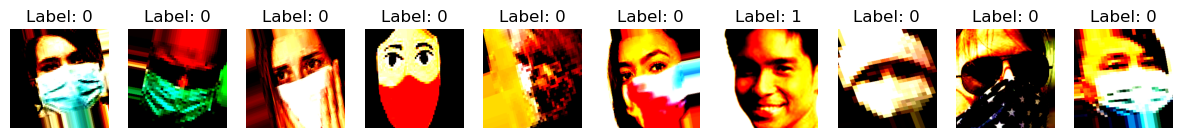


--- Valid Data ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

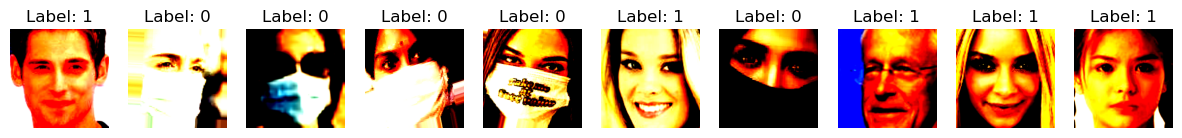

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



--- Test Data ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


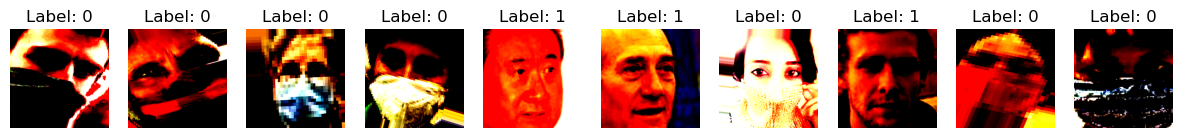

In [52]:
if dataset == "Mask_12K":
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.4166, 0.4652, 0.5689), (0.2206, 0.2246, 0.2444)) # 본 데이터셋의 Mean, Std 값
        ]
    )
    
    dataset_path = f"/mnt/e/Mask_12K" # 데이터셋 경로    
    train_DS = datasets.ImageFolder(root=dataset_path, transform=transform) 
    # Default: train 70%, valid 15%, test 15%
    train_size = int(train_share * len(train_DS))
    valid_size = int(valid_share * len(train_DS))
    test_size = len(train_DS) - train_size - valid_size
    train_DS, val_DS, test_DS = random_split(train_DS, [train_size, valid_size, test_size])

    train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
    val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
    test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

    train_loader = DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)
    
    # 적합하게 라벨링 되어있는지 랜덤으로 가져와서 테스트하는 용도
    dataloaders = { 'Train': train_DL, 'Valid':val_DL, 'Test': test_DL }
    show_random_images(dataloaders, n=10)

### 모델 설정

In [53]:
# 사용할 모델 선택
if model_type == "resnet18":
    model = resnet18(num_classes=num_classes).to(DEVICE)
elif model_type == "resnet34":
    model = resnet34(num_classes=num_classes).to(DEVICE)
elif model_type == "resnet50":
    model = resnet50(num_classes=num_classes).to(DEVICE)
elif model_type == "resnet101":
    model = resnet101(num_classes=num_classes).to(DEVICE)
elif model_type == "resnet152":
    model = resnet152(num_classes=num_classes).to(DEVICE)

print(model) # 모델 구성 확인
x_batch, _ = next(iter(train_DL)) 
print(model(x_batch.to(DEVICE)).shape)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage1): Sequential(
    (0): BasicBlock(
      (residual): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (residual): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1

### 학습 및 검증

In [54]:
optimizer = optim.Adam(model.parameters(), lr=LR)

# ReduceLROnPlateau # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# 후에 step에서 넣는 값(여기서는 val_loss)의 변화를 추적하여 LR 값을 조정하는 방식.
# 여기서는 val_loss가 연속적인 EPOCH 10(patience)회 동안 낮아지지(min) 않을 경우, 
# 새로운 LR 값을 LR * 0.1(factor)을 계산하여 생성한다. 단, 새로운 LR 값은 0(min_lr)을 넘어야한다.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=1e-4, threshold_mode='rel', min_lr=0, verbose=False)

train_losses = []
val_losses = []

best_val_loss = float('inf')
for ep in range(EPOCH):
    model.train() # (1) train - mode 전환
    train_loss = 0.0

    with tqdm(train_DL) as tepoch: # 진행도 체크용
        # Training Loop
        for x_batch, y_batch in train_DL: # (2) train - dataloader에서 이미지 및 라벨 한 묶음 가져오기
            tepoch.set_description(f"Epoch {ep+1} / {EPOCH}")
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # (3) train - 순전파, 역전파 진행
            optimizer.zero_grad() # gradient 누적을 막기 위한 초기화
            y_hat = model(x_batch) # inference
            loss = criterion(y_hat, y_batch)
            loss.backward() # backpropagation
            optimizer.step() # weight update

            train_loss += loss.item()

        train_loss /= len(train_DL)
        train_losses.append(train_loss)
        
        # (4) val - mode 전환
        model.eval()
        val_loss = 0.0
        with torch.no_grad(): # gradient 자동 계산 X / val, test땐 gradient 계산이 필요없으니
            for x_batch, y_batch in val_DL: # (5) val - dataloader에서 이미지 및 라벨 한 묶음 가져오기
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                # (6) val - 순전파, 역전파 진행
                y_hat = model(x_batch) # inference 결과
                loss = criterion(y_hat, y_batch) # loss check
                val_loss += loss.item()
        
        val_loss /= len(val_DL)
        val_losses.append(val_loss)        
        print(f"Epoch [{ep+1}/{EPOCH}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # (7) Scheduler로 lr 값 업데이트
        if scheduler is not None:
            # 앞서 확인했듯이 ReduceLROnPlateau는 매 사이클마다 확인하는 메트릭이 필요함. 여기서는 val_loss의 값을 기준으로 한다.
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau): 
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # (8) 데이터 저장
        # 베스트 모델만 저장함. 여기서 베스트 모델은 val_loss 값이 낮은 것.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, save_model_path)
            SaveToONNX(model, save_onnx_path)


Epoch 1 / 300:   0%|          | 0/129 [01:26<?, ?it/s]

Epoch [1/300], Train Loss: 0.3962, Val Loss: 0.3792


Epoch 1 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 2 / 300:   0%|          | 0/129 [01:33<?, ?it/s]

Epoch [2/300], Train Loss: 0.3510, Val Loss: 0.3583


Epoch 2 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 3 / 300:   0%|          | 0/129 [01:33<?, ?it/s]

Epoch [3/300], Train Loss: 0.3456, Val Loss: 0.3510


Epoch 3 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 4 / 300:   0%|          | 0/129 [01:35<?, ?it/s]

Epoch [4/300], Train Loss: 0.3374, Val Loss: 0.3438


Epoch 4 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 5 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [5/300], Train Loss: 0.3370, Val Loss: 0.4259


Epoch 6 / 300:   0%|          | 0/129 [01:43<?, ?it/s]

Epoch [6/300], Train Loss: 0.3321, Val Loss: 0.3315


Epoch 6 / 300:   0%|          | 0/129 [02:01<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 7 / 300:   0%|          | 0/129 [01:39<?, ?it/s]

Epoch [7/300], Train Loss: 0.3291, Val Loss: 0.3291


Epoch 7 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 8 / 300:   0%|          | 0/129 [01:33<?, ?it/s]

Epoch [8/300], Train Loss: 0.3294, Val Loss: 0.3272


Epoch 8 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 9 / 300:   0%|          | 0/129 [01:35<?, ?it/s]

Epoch [9/300], Train Loss: 0.3251, Val Loss: 0.3238


Epoch 9 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 10 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [10/300], Train Loss: 0.3256, Val Loss: 0.3258


Epoch 11 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [11/300], Train Loss: 0.3253, Val Loss: 0.3343


Epoch 12 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [12/300], Train Loss: 0.3241, Val Loss: 0.3249


Epoch 13 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [13/300], Train Loss: 0.3232, Val Loss: 0.3481


Epoch 14 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [14/300], Train Loss: 0.3220, Val Loss: 0.3284


Epoch 15 / 300:   0%|          | 0/129 [02:43<?, ?it/s]


Epoch [15/300], Train Loss: 0.3212, Val Loss: 0.3257


Epoch 16 / 300:   0%|          | 0/129 [02:05<?, ?it/s]

Epoch [16/300], Train Loss: 0.3193, Val Loss: 0.3233


Epoch 16 / 300:   0%|          | 0/129 [02:22<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 17 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [17/300], Train Loss: 0.3205, Val Loss: 0.3240


Epoch 18 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Epoch [18/300], Train Loss: 0.3203, Val Loss: 0.3269


Epoch 19 / 300:   0%|          | 0/129 [01:37<?, ?it/s]

Epoch [19/300], Train Loss: 0.3213, Val Loss: 0.3232


Epoch 19 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 20 / 300:   0%|          | 0/129 [02:20<?, ?it/s]

Epoch [20/300], Train Loss: 0.3192, Val Loss: 0.3215


Epoch 20 / 300:   0%|          | 0/129 [02:53<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 21 / 300:   0%|          | 0/129 [01:41<?, ?it/s]

Epoch [21/300], Train Loss: 0.3172, Val Loss: 0.3215


Epoch 21 / 300:   0%|          | 0/129 [02:00<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 22 / 300:   0%|          | 0/129 [01:33<?, ?it/s]

Epoch [22/300], Train Loss: 0.3177, Val Loss: 0.3198


Epoch 22 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 23 / 300:   0%|          | 0/129 [01:43<?, ?it/s]


Epoch [23/300], Train Loss: 0.3173, Val Loss: 0.3215


Epoch 24 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [24/300], Train Loss: 0.3164, Val Loss: 0.3257


Epoch 25 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [25/300], Train Loss: 0.3168, Val Loss: 0.3374


Epoch 26 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [26/300], Train Loss: 0.3176, Val Loss: 0.3216


Epoch 27 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [27/300], Train Loss: 0.3186, Val Loss: 0.3355


Epoch 28 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [28/300], Train Loss: 0.3217, Val Loss: 0.3232


Epoch 29 / 300:   0%|          | 0/129 [01:26<?, ?it/s]

Epoch [29/300], Train Loss: 0.3160, Val Loss: 0.3185


Epoch 29 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 30 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [30/300], Train Loss: 0.3166, Val Loss: 0.3251


Epoch 31 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [31/300], Train Loss: 0.3190, Val Loss: 0.3255


Epoch 32 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [32/300], Train Loss: 0.3182, Val Loss: 0.3240


Epoch 33 / 300:   0%|          | 0/129 [01:35<?, ?it/s]

Epoch [33/300], Train Loss: 0.3159, Val Loss: 0.3184


Epoch 33 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 34 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [34/300], Train Loss: 0.3151, Val Loss: 0.3191


Epoch 35 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [35/300], Train Loss: 0.3160, Val Loss: 0.3199


Epoch 36 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [36/300], Train Loss: 0.3160, Val Loss: 0.3187


Epoch 37 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [37/300], Train Loss: 0.3157, Val Loss: 0.3192


Epoch 38 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [38/300], Train Loss: 0.3146, Val Loss: 0.3197


Epoch 39 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [39/300], Train Loss: 0.3143, Val Loss: 0.3235


Epoch 40 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [40/300], Train Loss: 0.3155, Val Loss: 0.3186


Epoch 41 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [41/300], Train Loss: 0.3146, Val Loss: 0.3189


Epoch 42 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [42/300], Train Loss: 0.3139, Val Loss: 0.3198


Epoch 43 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [43/300], Train Loss: 0.3150, Val Loss: 0.3226


Epoch 44 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [44/300], Train Loss: 0.3149, Val Loss: 0.3229


Epoch 45 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [45/300], Train Loss: 0.3140, Val Loss: 0.3208


Epoch 46 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [46/300], Train Loss: 0.3135, Val Loss: 0.3198


Epoch 47 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [47/300], Train Loss: 0.3133, Val Loss: 0.3199


Epoch 48 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [48/300], Train Loss: 0.3135, Val Loss: 0.3190


Epoch 49 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [49/300], Train Loss: 0.3133, Val Loss: 0.3195


Epoch 50 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [50/300], Train Loss: 0.3133, Val Loss: 0.3193


Epoch 51 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [51/300], Train Loss: 0.3134, Val Loss: 0.3189


Epoch 52 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [52/300], Train Loss: 0.3134, Val Loss: 0.3192


Epoch 53 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [53/300], Train Loss: 0.3133, Val Loss: 0.3193


Epoch 54 / 300:   0%|          | 0/129 [01:35<?, ?it/s]

Epoch [54/300], Train Loss: 0.3134, Val Loss: 0.3183


Epoch 54 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 55 / 300:   0%|          | 0/129 [01:43<?, ?it/s]


Epoch [55/300], Train Loss: 0.3133, Val Loss: 0.3189


Epoch 56 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [56/300], Train Loss: 0.3133, Val Loss: 0.3189


Epoch 57 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [57/300], Train Loss: 0.3134, Val Loss: 0.3185


Epoch 58 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [58/300], Train Loss: 0.3133, Val Loss: 0.3193


Epoch 59 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [59/300], Train Loss: 0.3133, Val Loss: 0.3189


Epoch 60 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Epoch [60/300], Train Loss: 0.3133, Val Loss: 0.3188


Epoch 61 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [61/300], Train Loss: 0.3134, Val Loss: 0.3187


Epoch 62 / 300:   0%|          | 0/129 [01:32<?, ?it/s]

Epoch [62/300], Train Loss: 0.3133, Val Loss: 0.3181


Epoch 62 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 63 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [63/300], Train Loss: 0.3133, Val Loss: 0.3186


Epoch 64 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [64/300], Train Loss: 0.3133, Val Loss: 0.3183


Epoch 65 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [65/300], Train Loss: 0.3135, Val Loss: 0.3187


Epoch 66 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Epoch [66/300], Train Loss: 0.3134, Val Loss: 0.3202


Epoch 67 / 300:   0%|          | 0/129 [01:43<?, ?it/s]


Epoch [67/300], Train Loss: 0.3133, Val Loss: 0.3195


Epoch 68 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [68/300], Train Loss: 0.3133, Val Loss: 0.3188


Epoch 69 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [69/300], Train Loss: 0.3133, Val Loss: 0.3188


Epoch 70 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [70/300], Train Loss: 0.3133, Val Loss: 0.3190


Epoch 71 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [71/300], Train Loss: 0.3133, Val Loss: 0.3187


Epoch 72 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [72/300], Train Loss: 0.3133, Val Loss: 0.3183


Epoch 73 / 300:   0%|          | 0/129 [01:31<?, ?it/s]

Epoch [73/300], Train Loss: 0.3133, Val Loss: 0.3180


Epoch 73 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 74 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [74/300], Train Loss: 0.3133, Val Loss: 0.3182


Epoch 75 / 300:   0%|          | 0/129 [01:35<?, ?it/s]

Epoch [75/300], Train Loss: 0.3133, Val Loss: 0.3178


Epoch 75 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 76 / 300:   0%|          | 0/129 [01:37<?, ?it/s]

Epoch [76/300], Train Loss: 0.3136, Val Loss: 0.3160


Epoch 76 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Exported model has been tested with ONNXRuntime, and the result looks good!


Epoch 77 / 300:   0%|          | 0/129 [01:59<?, ?it/s]


Epoch [77/300], Train Loss: 0.3134, Val Loss: 0.3170


Epoch 78 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [78/300], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 79 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [79/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 80 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [80/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 81 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [81/300], Train Loss: 0.3133, Val Loss: 0.3166


Epoch 82 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [82/300], Train Loss: 0.3133, Val Loss: 0.3165


Epoch 83 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [83/300], Train Loss: 0.3134, Val Loss: 0.3169


Epoch 84 / 300:   0%|          | 0/129 [02:00<?, ?it/s]


Epoch [84/300], Train Loss: 0.3133, Val Loss: 0.3167


Epoch 85 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [85/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 86 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [86/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 87 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [87/300], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 88 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [88/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 89 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Epoch [89/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 90 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [90/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 91 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [91/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 92 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [92/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 93 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [93/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 94 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [94/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 95 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [95/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 96 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [96/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 97 / 300:   0%|          | 0/129 [01:46<?, ?it/s]


Epoch [97/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 98 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [98/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 99 / 300:   0%|          | 0/129 [02:02<?, ?it/s]


Epoch [99/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 100 / 300:   0%|          | 0/129 [01:59<?, ?it/s]


Epoch [100/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 101 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [101/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 102 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [102/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 103 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [103/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 104 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [104/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 105 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [105/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 106 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [106/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 107 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [107/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 108 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [108/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 109 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [109/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 110 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [110/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 111 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [111/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 112 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [112/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 113 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [113/300], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 114 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [114/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 115 / 300:   0%|          | 0/129 [01:46<?, ?it/s]


Epoch [115/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 116 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [116/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 117 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [117/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 118 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [118/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 119 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [119/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 120 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [120/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 121 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [121/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 122 / 300:   0%|          | 0/129 [02:44<?, ?it/s]


Epoch [122/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 123 / 300:   0%|          | 0/129 [02:24<?, ?it/s]


Epoch [123/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 124 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [124/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 125 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [125/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 126 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [126/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 127 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [127/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 128 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [128/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 129 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [129/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 130 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [130/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 131 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [131/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 132 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [132/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 133 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [133/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 134 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [134/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 135 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [135/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 136 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [136/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 137 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [137/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 138 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [138/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 139 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [139/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 140 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [140/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 141 / 300:   0%|          | 0/129 [01:41<?, ?it/s]


Epoch [141/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 142 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [142/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 143 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [143/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 144 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [144/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 145 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [145/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 146 / 300:   0%|          | 0/129 [01:43<?, ?it/s]


Epoch [146/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 147 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [147/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 148 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [148/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 149 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [149/300], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 150 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [150/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 151 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [151/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 152 / 300:   0%|          | 0/129 [01:41<?, ?it/s]


Epoch [152/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 153 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [153/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 154 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [154/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 155 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [155/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 156 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [156/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 157 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [157/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 158 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [158/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 159 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [159/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 160 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [160/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 161 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [161/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 162 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [162/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 163 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [163/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 164 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [164/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 165 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [165/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 166 / 300:   0%|          | 0/129 [01:46<?, ?it/s]


Epoch [166/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 167 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [167/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 168 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Epoch [168/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 169 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [169/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 170 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [170/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 171 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [171/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 172 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [172/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 173 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [173/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 174 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [174/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 175 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [175/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 176 / 300:   0%|          | 0/129 [01:41<?, ?it/s]


Epoch [176/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 177 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [177/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 178 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [178/300], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 179 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [179/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 180 / 300:   0%|          | 0/129 [01:46<?, ?it/s]


Epoch [180/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 181 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Epoch [181/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 182 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [182/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 183 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [183/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 184 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [184/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 185 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [185/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 186 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [186/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 187 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [187/300], Train Loss: 0.3133, Val Loss: 0.3178


Epoch 188 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [188/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 189 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [189/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 190 / 300:   0%|          | 0/129 [01:46<?, ?it/s]


Epoch [190/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 191 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Epoch [191/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 192 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [192/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 193 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [193/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 194 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [194/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 195 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [195/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 196 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [196/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 197 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [197/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 198 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [198/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 199 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [199/300], Train Loss: 0.3135, Val Loss: 0.3169


Epoch 200 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [200/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 201 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [201/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 202 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [202/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 203 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [203/300], Train Loss: 0.3133, Val Loss: 0.3176


Epoch 204 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [204/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 205 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [205/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 206 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [206/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 207 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [207/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 208 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [208/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 209 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [209/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 210 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [210/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 211 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [211/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 212 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [212/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 213 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [213/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 214 / 300:   0%|          | 0/129 [02:00<?, ?it/s]


Epoch [214/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 215 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [215/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 216 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [216/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 217 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [217/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 218 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [218/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 219 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [219/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 220 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [220/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 221 / 300:   0%|          | 0/129 [01:45<?, ?it/s]


Epoch [221/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 222 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [222/300], Train Loss: 0.3134, Val Loss: 0.3171


Epoch 223 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [223/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 224 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [224/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 225 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [225/300], Train Loss: 0.3133, Val Loss: 0.3174


Epoch 226 / 300:   0%|          | 0/129 [01:47<?, ?it/s]


Epoch [226/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 227 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [227/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 228 / 300:   0%|          | 0/129 [01:46<?, ?it/s]


Epoch [228/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 229 / 300:   0%|          | 0/129 [01:46<?, ?it/s]


Epoch [229/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 230 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [230/300], Train Loss: 0.3134, Val Loss: 0.3171


Epoch 231 / 300:   0%|          | 0/129 [01:44<?, ?it/s]


Epoch [231/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 232 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [232/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 233 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [233/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 234 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [234/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 235 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [235/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 236 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [236/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 237 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [237/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 238 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [238/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 239 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [239/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 240 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [240/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 241 / 300:   0%|          | 0/129 [01:50<?, ?it/s]


Epoch [241/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 242 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [242/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 243 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [243/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 244 / 300:   0%|          | 0/129 [02:00<?, ?it/s]


Epoch [244/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 245 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [245/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 246 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [246/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 247 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [247/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 248 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [248/300], Train Loss: 0.3133, Val Loss: 0.3176


Epoch 249 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [249/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 250 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [250/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 251 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [251/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 252 / 300:   0%|          | 0/129 [02:02<?, ?it/s]


Epoch [252/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 253 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [253/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 254 / 300:   0%|          | 0/129 [01:53<?, ?it/s]


Epoch [254/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 255 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [255/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 256 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [256/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 257 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [257/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 258 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [258/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 259 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [259/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 260 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [260/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 261 / 300:   0%|          | 0/129 [01:48<?, ?it/s]


Epoch [261/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 262 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [262/300], Train Loss: 0.3134, Val Loss: 0.3171


Epoch 263 / 300:   0%|          | 0/129 [02:00<?, ?it/s]


Epoch [263/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 264 / 300:   0%|          | 0/129 [02:00<?, ?it/s]


Epoch [264/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 265 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [265/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 266 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [266/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 267 / 300:   0%|          | 0/129 [02:03<?, ?it/s]


Epoch [267/300], Train Loss: 0.3133, Val Loss: 0.3177


Epoch 268 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [268/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 269 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [269/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 270 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [270/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 271 / 300:   0%|          | 0/129 [01:59<?, ?it/s]


Epoch [271/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 272 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [272/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 273 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [273/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 274 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [274/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 275 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [275/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 276 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [276/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 277 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [277/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 278 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [278/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 279 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [279/300], Train Loss: 0.3133, Val Loss: 0.3181


Epoch 280 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [280/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 281 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [281/300], Train Loss: 0.3133, Val Loss: 0.3171


Epoch 282 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [282/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 283 / 300:   0%|          | 0/129 [01:56<?, ?it/s]


Epoch [283/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 284 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [284/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 285 / 300:   0%|          | 0/129 [01:58<?, ?it/s]


Epoch [285/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 286 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [286/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 287 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [287/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 288 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [288/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 289 / 300:   0%|          | 0/129 [01:57<?, ?it/s]


Epoch [289/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 290 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [290/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 291 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [291/300], Train Loss: 0.3133, Val Loss: 0.3175


Epoch 292 / 300:   0%|          | 0/129 [01:49<?, ?it/s]


Epoch [292/300], Train Loss: 0.3133, Val Loss: 0.3168


Epoch 293 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [293/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 294 / 300:   0%|          | 0/129 [01:54<?, ?it/s]


Epoch [294/300], Train Loss: 0.3133, Val Loss: 0.3172


Epoch 295 / 300:   0%|          | 0/129 [01:59<?, ?it/s]


Epoch [295/300], Train Loss: 0.3133, Val Loss: 0.3170


Epoch 296 / 300:   0%|          | 0/129 [01:52<?, ?it/s]


Epoch [296/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 297 / 300:   0%|          | 0/129 [01:51<?, ?it/s]


Epoch [297/300], Train Loss: 0.3133, Val Loss: 0.3169


Epoch 298 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [298/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 299 / 300:   0%|          | 0/129 [01:55<?, ?it/s]


Epoch [299/300], Train Loss: 0.3133, Val Loss: 0.3173


Epoch 300 / 300:   0%|          | 0/129 [01:51<?, ?it/s]

Epoch [300/300], Train Loss: 0.3133, Val Loss: 0.3171


### 학습 결과 그래프

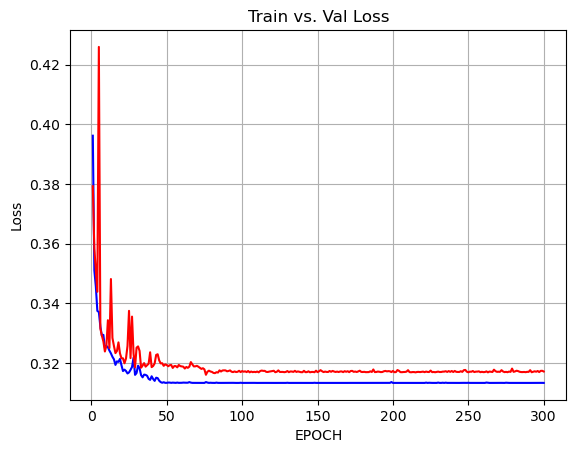

In [55]:
# EPOCH 별 val, train loss 체크
plt.plot(range(1, EPOCH+1), train_losses, 'b')
plt.plot(range(1, EPOCH+1), val_losses, 'r-')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('Train vs. Val Loss')
plt.grid()

### 테스트

In [56]:
model.eval()

test_loss = 0.0
correct = 0
total = 0

# Test Loop
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        y_hat = model(x_batch) # inference
        loss = criterion(y_hat, y_batch)
        test_loss += loss.item()
        
        _, predicted = torch.max(y_hat, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = 100.0 * correct / total
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Test Loss: 0.3155, Accuracy: 99.77%
